<h2>Install Dependencies</h2>

In [16]:
!pip install tensorflow==2.16.1

In [18]:
!pip install opencv-python matplotlib --user

  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


<h2>Import Dependencies</h2>

In [22]:
pip install --user --force-reinstall matplotlib

  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.0-cp312-cp312-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached packaging-24.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached pillow-10.3.0-cp312-cp312-win_amd64.whl.metadata (9.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.0-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# Standard Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Import Tensorflow Dependencies -Funtional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


<h2>Set GPU Growth</h2>

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>Folder Structure</h2>

In [13]:
# Set Path
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Create the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
import uuid

<h2>Collect Positives and Anchors</h2>

In [77]:
# Establish Connection through webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    #Cut down frame to 250x250 pixels
    frame = frame[120:120+250, 200:200+250, :]

    # Collect Anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write the anchor image
        cv2.imwrite(imgname, frame)
        
    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write the anchor image
        cv2.imwrite(imgname, frame)
        
    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Release the Webcam
cap.release()
# Close the image show frame 
cv2.destroyAllWindows()
                                    

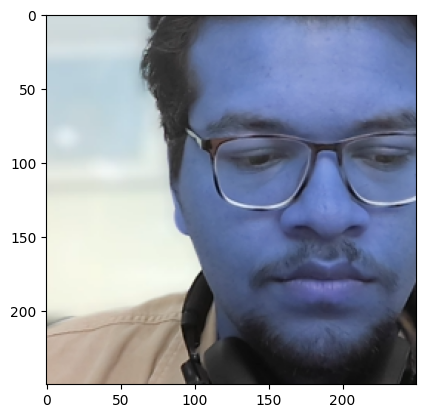

In [34]:
plt.imshow(frame[120:120+250, 200:200+250, :])

<H1>Load and Preprocess</H1>

<h2>Image Directories</h2>

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(300)

<h2>Scale and Resize</h2>

In [27]:
def preprocess(file_path):
    # Read the iamge from the fie path
    byte_img = tf.io.read_file(file_path)
    # Load the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    return img

<h2>Labelled Dataset</h2>

In [28]:
# (anchor, positive) => 1,1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0,0

In [29]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [32]:
samples = data.as_numpy_iterator()
example = samples.next()

<h2>Build, Train and Test Partition</h2>

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [35]:
res = preprocess_twin(*example)

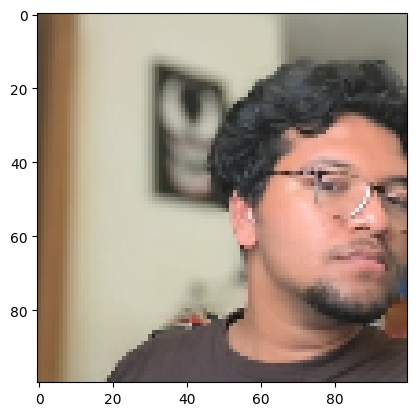

In [41]:
plt.imshow(res[1])

In [42]:
res[2]

1.0

In [43]:
# Dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [48]:
samples = data.as_numpy_iterator()


In [70]:
samp = samples.next()


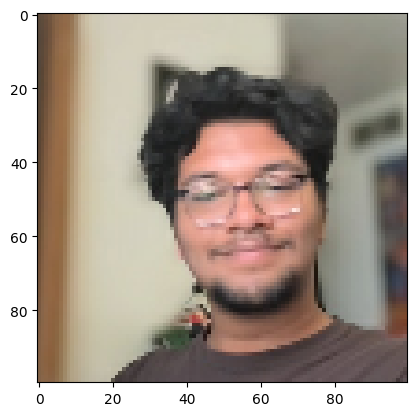

In [75]:
plt.imshow(samp[1])